# Comparative Analysis of Visits

In [5]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
sys.path.insert(0,package_path + '/src/')
import yaml
from hiv_support_package import visit_features,target_creation
from datetime import timedelta
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Import Libraries

In [4]:
def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")
            
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")
            
def date_visit_conversion(df,visit_col: str,visit_year: str, visit_month: str):
    if df is not None:
        try:
            df = df.copy()
            df[visit_col] = pd.to_datetime(df[visit_col],errors='coerce')
            df[visit_year] = df[visit_col].dt.year
            df[visit_month] = df[visit_col].dt.month
            return df
        except Exception as e:
            print(f"Exception on converting visit date with error: {e}") 
            
def plot_visit_date(df, primary_key: str, data_name: str):
    if df is not None:
        df_sub = df.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")
        df_sub_slice = df_sub.groupby("VISIT_YEAR").agg(
            {primary_key: lambda x: x.nunique()}
        )
        df_sub_slice.reset_index(inplace=True)
        df_sub_slice["VISIT_YEAR"] = df_sub_slice["VISIT_YEAR"].astype("int")
        ax_sub = sns.barplot(x="VISIT_YEAR", y=primary_key, data=df_sub_slice)
        ax_sub.set(xlabel="Year of Visit", ylabel="Number of Patient Visits")
        ax_sub.set_title(f"'Trend of Yearly Patient Visits:{data_name}'")
        plt.xticks(rotation=60)
        
def convert_to_datetime(df,date_col: str):
    if df is not None:
        try:
            df[date_col] = pd.to_datetime(df[date_col],errors='coerce')
            return df
        except Exception as e:
            print(f"Exception on converting to datetime with error: {e}")      

def print_min_max_dates(df,date_col: str,type_date: str):
    if df is not None:
        return print(f" The earliest {type_date} date is: {df[date_col].min()}, and the most recent {type_date} date is {df[date_col].max()}") 
    
def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 

In [6]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [7]:
# Get File paths and file names
input_root = config['rise_files']['raw_data_path']
clinic_file = config['rise_files']['raw_clinic_file']
otz_file = config['rise_files']['raw_otz_file']

# paths
clinic_input = input_root + clinic_file
print(clinic_input)

/data/rise_data/ClinicData.xlsx


In [5]:
#%%time
df = load_excel_sheet(clinic_input)

In [6]:
df = df.sort_values(by=['PATIENT_ID','DATE_VISIT'])

In [7]:
#ART_LIST = ['ART First Line Adult','ART Second Line Adult','ART First Line Children','ART Second Line Children','Third Line'] 

In [9]:
mapping_dict = {'name':'State','name.1':'L.G.A','name.2':'Facility Name'}
df.rename(columns=mapping_dict, inplace=True)

In [10]:
df['DATE_VISIT'] = pd.to_datetime(df['DATE_VISIT'],errors='coerce')

In [12]:
df = df[~df['DATE_VISIT'].isnull()]

In [13]:
df = df.loc[(df['DATE_VISIT'] >= '2014-01-01 00:00:00') & (df['DATE_VISIT'] <= '2020-12-31 00:00:00')]

In [14]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','DATE_VISIT','FACILITY_ID'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 777402 rows
 
After deduplication the dataframe has 773342 rows


In [15]:
df = visit_features.generate_date_features(df,'DATE_VISIT')

Generating features for DATE_VISIT, starting with  rows:773,342; cols: 38
Generating features for DATE_VISIT,ending with  rows:773,342; cols: 50


In [17]:
def period_col(df):
    if df['EF_YEAR_DATE_VISIT'] < 2017:
        return 'Pre-2017'
    elif df['EF_YEAR_DATE_VISIT'] >= 2017:
        return 'Post-2017'
    else:
        return 'Other'   

In [18]:
df['ANALYSIS_PERIOD'] = df.apply(lambda row: period_col(row), axis=1)

In [19]:
df_pre = df[df['ANALYSIS_PERIOD'] == 'Pre-2017']
df_post = df[df['ANALYSIS_PERIOD'] == 'Post-2017']
df_ada = df[df['State'] == 'Adamawa']
df_akw = df[df['State'] == 'Akwa Ibom']
df_cross = df[df['State'] == 'Cross River']
df_niger = df[df['State'] == 'Niger']

df_ada_post = df_post[df_post['State'] == 'Adamawa']
df_akw_post = df_post[df_post['State'] == 'Akwa Ibom']
df_cross_post = df_post[df_post['State'] == 'Cross River']
df_niger_post = df_post[df_post['State'] == 'Niger']

df_2014 = df[df['EF_YEAR_DATE_VISIT'] == 2014]
df_2015 = df[df['EF_YEAR_DATE_VISIT'] == 2015]
df_2016 = df[df['EF_YEAR_DATE_VISIT'] == 2016]
df_2017 = df[df['EF_YEAR_DATE_VISIT'] == 2017]
df_2018 = df[df['EF_YEAR_DATE_VISIT'] == 2018]
df_2019 = df[df['EF_YEAR_DATE_VISIT'] == 2019]
df_2020 = df[df['EF_YEAR_DATE_VISIT'] == 2020]

In [20]:
df_line_plot = df.groupby(['EF_YEAR_DATE_VISIT','State','ANALYSIS_PERIOD']).agg({'PATIENT_ID':lambda x: x.nunique()})

In [21]:
df_line_plot = df_line_plot.reset_index()

In [22]:
fig = sns.lineplot(data=df_line_plot,x="EF_YEAR_DATE_VISIT",y="PATIENT_ID",hue="State")
plt.xlabel('Year of Visit', fontsize=13)
plt.ylabel('No. of Patients', fontsize=13)
plt.title('Number of Patients with a Pharmacy visit')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
#plt.savefig("../Figures/lineplot_pharmacy_patients.png",transparent=True,bbox_inches="tight")

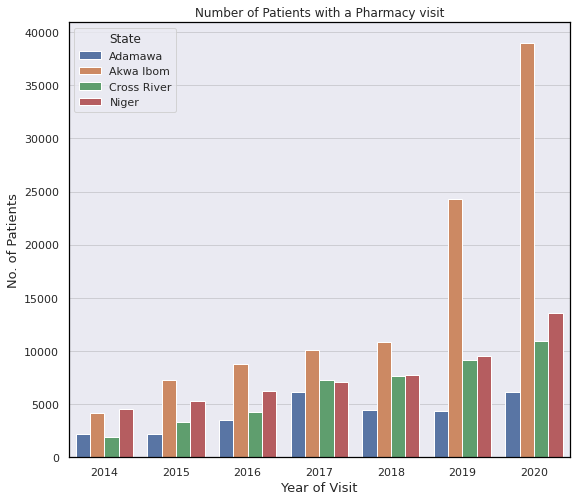

In [23]:
fig = sns.barplot(data=df_line_plot,x="EF_YEAR_DATE_VISIT",y="PATIENT_ID",hue="State")
plt.xlabel('Year of Visit', fontsize=13)
plt.ylabel('No. of Patients', fontsize=13)
plt.title('Number of Patients with a Pharmacy visit')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
#plt.savefig("../Figures/barplot_pharmacy_patients.png",transparent=True,bbox_inches="tight")

In [24]:
fig = sns.barplot(data=df_line_plot,x="ANALYSIS_PERIOD",y="PATIENT_ID",hue="State",ci=None)
plt.xlabel('Period of Analysis', fontsize=13)
plt.ylabel('No. of Patients', fontsize=13)
plt.legend(loc=2)
plt.title('Number of Patients with Pharmacy Visit: Pre 2017 vs Post 2017')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
#plt.savefig("../Figures/analysis_barplot_pharmacy_patients.png",transparent=True,bbox_inches="tight")

<AxesSubplot:xlabel='State', ylabel='PATIENT_ID'>

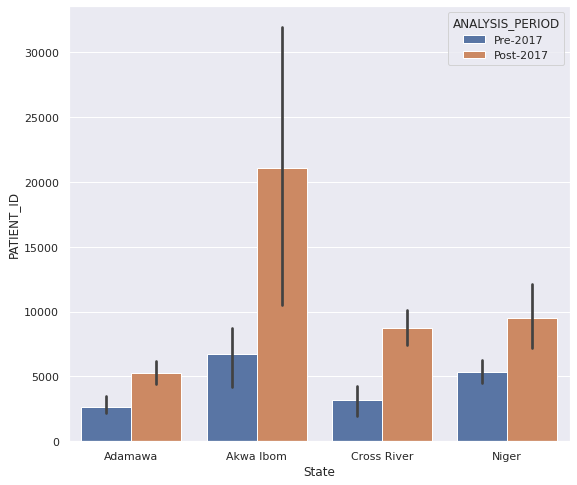

In [25]:
sns.barplot(data=df_line_plot,x="State",y="PATIENT_ID",hue="ANALYSIS_PERIOD")

#Patient Analysis:

In [26]:
df_max_visits = df.groupby(['PATIENT_ID','EF_YEAR_DATE_VISIT','State','ANALYSIS_PERIOD']).agg({'DATE_VISIT':lambda x: x.nunique()})

In [27]:
df_max_visits = df_max_visits.reset_index()

In [28]:
sns.barplot(data=df_max_visits,x="DATE_VISIT",y="PATIENT_ID",hue="ANALYSIS_PERIOD")

<AxesSubplot:xlabel='DATE_VISIT', ylabel='PATIENT_ID'>

In [29]:
df_max_visits['DATE_VISIT'].max()

80

In [30]:
visits = df[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

In [31]:
visits_pre = df_pre[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_post = df_post[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_ada = df_ada[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_akw = df_akw[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_cross = df_cross[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_niger = df_niger[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

In [32]:
visits_ada1 = df_ada_post[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_akw1 = df_akw_post[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_cross1 = df_cross_post[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_niger1 = df_niger_post[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

In [33]:
visits_2014 = df_2014[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2015 = df_2015[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2016 = df_2016[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2017 = df_2017[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2018 = df_2018[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2019 = df_2019[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')
visits_2020 = df_2020[['PATIENT_ID','DATE_VISIT']].groupby(['PATIENT_ID']).count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

In [34]:
ave_visits1 = visits.query('DATE_VISIT < 40')
fig = sns.barplot(ave_visits1['DATE_VISIT'].astype('int'), ave_visits1['PATIENT_ID'].astype('int'))
#plt.xticks(fontsize=7)
plt.yticks(ticks=[1500,3000,4500,6000,7500,9000,10500,12000,13500,15000], labels=['1,5k','3k','4,5k','6k','7,5k','9k','10,5k','12k','13,5k','15k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
plt.title('Max Number of Pharmacy Visits per Patient')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
#plt.savefig("../Figures/pharmacy_visits_postdeduplication.png",transparent=True,bbox_inches="tight")

## Pre 2017/ Post 2017

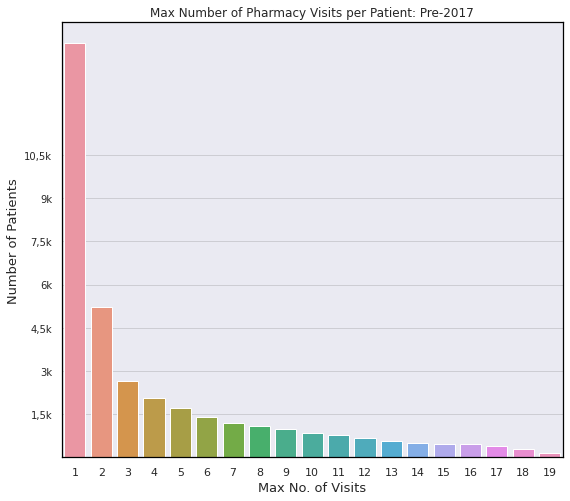

In [35]:
ave_visits1 = visits_pre.query('DATE_VISIT < 20')
fig = sns.barplot(ave_visits1['DATE_VISIT'].astype('int'), ave_visits1['PATIENT_ID'].astype('int'))
#plt.xticks(fontsize=7)
plt.yticks(ticks=[1500,3000,4500,6000,7500,9000,10500], labels=['1,5k','3k','4,5k','6k','7,5k','9k','10,5k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
plt.title('Max Number of Pharmacy Visits per Patient: Pre-2017')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
#plt.savefig("../Figures/pharmacy_visits_postdeduplication.png",transparent=True,bbox_inches="tight")

In [36]:
ave_visits1 = visits_post.query('DATE_VISIT < 35')
fig = sns.barplot(ave_visits1['DATE_VISIT'].astype('int'), ave_visits1['PATIENT_ID'].astype('int'))
#plt.xticks(fontsize=7)
plt.yticks(ticks=[4000,8000,12000,16000,20000,24000,28000], labels=['4k','8k','12k','16k','20k','24k','28k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
plt.title('Max Number of Pharmacy Visits per Patient: Post-2017')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
plt.savefig("../Figures/clinic_visits_postdeduplication.png",transparent=True,bbox_inches="tight")

In [37]:
ave_visits1 = visits_pre.query('DATE_VISIT < 21')
ave_visits2 = visits_post.query('DATE_VISIT < 35')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Maximum Number of Clinic Visits per Patient')
sns.barplot(ax=axes[0],data= ave_visits1,x=ave_visits1['DATE_VISIT'].astype('int'), y = ave_visits1['PATIENT_ID'].astype('int'))
axes[0].set_title('Pre-2017')
axes[0].set_xlabel('Max No. of Visits', fontsize=13)
axes[0].set_ylabel('No. of Patients', fontsize=13)
axes[0].set_yticks([1500,3000,4500,6000,7500,9000,10500,12000])
axes[0].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k','9k','10,5k','12k'], fontsize=10)
axes[0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0].spines['bottom'].set_color('black')
axes[0].spines['top'].set_color('black') 
axes[0].spines['right'].set_color('black')
axes[0].spines['left'].set_color('black')
sns.barplot(ax=axes[1],data= ave_visits2,x=ave_visits2['DATE_VISIT'].astype('int'),y =  ave_visits2['PATIENT_ID'].astype('int'))
axes[1].set_title('Post-2017')
axes[1].set_xlabel('Max No. of Visits', fontsize=13)
axes[1].set_ylabel('No. of Patients', fontsize=13)
axes[1].set_yticks([1500,3000,4500,6000,7500,9000,10500,12000])
axes[1].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k','9k','10,5k','12k'], fontsize=10)
axes[1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1].spines['bottom'].set_color('black')
axes[1].spines['top'].set_color('black') 
axes[1].spines['right'].set_color('black')
axes[1].spines['left'].set_color('black')
plt.savefig("../Figures/clinic_visits_pre_2017_post.png",transparent=True,bbox_inches="tight")

## By State

In [38]:
ave_visits1 = visits_ada.query('DATE_VISIT < 30')
ave_visits2 = visits_akw.query('DATE_VISIT < 30')
ave_visits3 = visits_cross.query('DATE_VISIT < 30')
ave_visits4 = visits_niger.query('DATE_VISIT < 30')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=3)
fig.suptitle('Maximum Number of Clinic Visits per Patient by State')

sns.barplot(ax=axes[0,0],data= ave_visits1,x=ave_visits1['DATE_VISIT'].astype('int'), y = ave_visits1['PATIENT_ID'].astype('int'))
axes[0,0].set_title('Adamawa')
axes[0,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,0].set_ylabel('No. of Patients', fontsize=13)
axes[0,0].set_yticks([1500,3000,4500,6000,7500])
axes[0,0].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k'], fontsize=10)
axes[0,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,0].spines['bottom'].set_color('black')
axes[0,0].spines['top'].set_color('black') 
axes[0,0].spines['right'].set_color('black')
axes[0,0].spines['left'].set_color('black')

sns.barplot(ax=axes[0,1],data= ave_visits2,x=ave_visits2['DATE_VISIT'].astype('int'),y =  ave_visits2['PATIENT_ID'].astype('int'))
axes[0,1].set_title('Akwa Ibom')
axes[0,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,1].set_ylabel('No. of Patients', fontsize=13)
axes[0,1].set_yticks([3000,6000,12000,15000,18000])
axes[0,1].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k'], fontsize=10)
axes[0,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,1].spines['bottom'].set_color('black')
axes[0,1].spines['top'].set_color('black') 
axes[0,1].spines['right'].set_color('black')
axes[0,1].spines['left'].set_color('black')

sns.barplot(ax=axes[1,0],data= ave_visits3,x=ave_visits3['DATE_VISIT'].astype('int'), y = ave_visits3['PATIENT_ID'].astype('int'))
axes[1,0].set_title('Cross River',fontsize=13)
axes[1,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,0].set_ylabel('No. of Patients', fontsize=13)
axes[1,0].set_yticks([500,1000,1500,2000,2500,3000])
axes[1,0].set_yticklabels(['0,5k','1k','1,5k','2k','2,5k','3k'], fontsize=10)
axes[1,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,0].spines['bottom'].set_color('black')
axes[1,0].spines['top'].set_color('black') 
axes[1,0].spines['right'].set_color('black')
axes[1,0].spines['left'].set_color('black')

sns.barplot(ax=axes[1,1],data= ave_visits4,x=ave_visits4['DATE_VISIT'].astype('int'),y =  ave_visits4['PATIENT_ID'].astype('int'))
axes[1,1].set_title('Niger',fontsize=13)
axes[1,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,1].set_ylabel('No. of Patients', fontsize=13)
axes[1,1].set_yticks([500,1000,1500,2000,2500,3000])
axes[1,1].set_yticklabels(['0,5k','1k','1,5k','2k','2,5k','3k'], fontsize=10)
axes[1,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,1].spines['bottom'].set_color('black')
axes[1,1].spines['top'].set_color('black') 
axes[1,1].spines['right'].set_color('black')
axes[1,1].spines['left'].set_color('black')
plt.subplots_adjust(top=0.91)
plt.savefig("../Figures/clinic_visits_by_state.png",transparent=True,bbox_inches="tight")

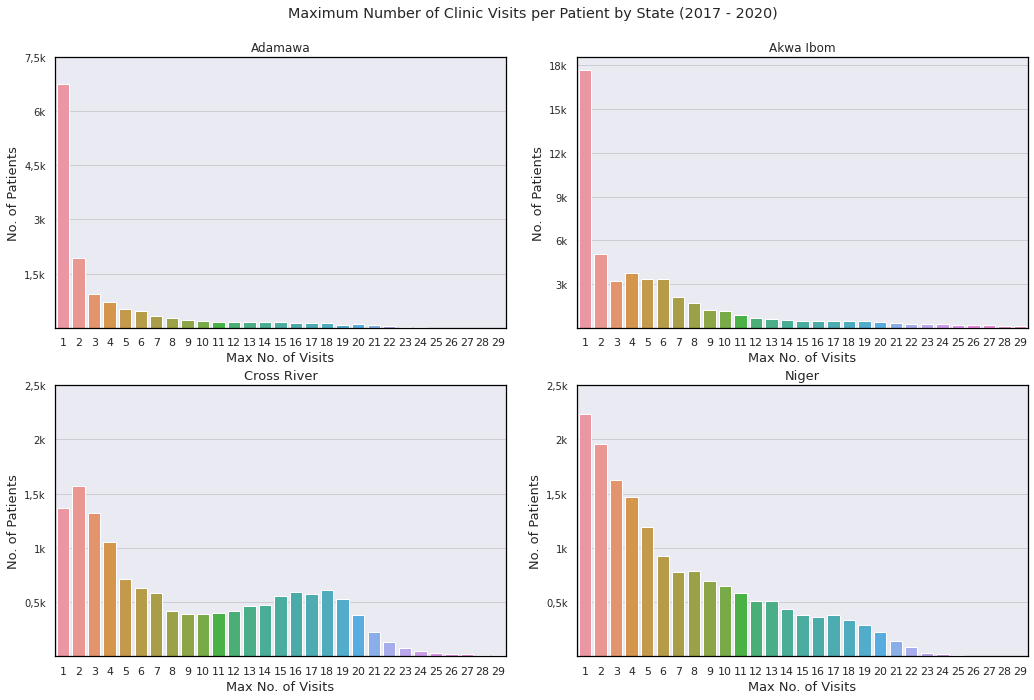

In [39]:
ave_visits11 = visits_ada1.query('DATE_VISIT < 30')
ave_visits22 = visits_akw1.query('DATE_VISIT < 30')
ave_visits33 = visits_cross1.query('DATE_VISIT < 30')
ave_visits44 = visits_niger1.query('DATE_VISIT < 30')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=3)
fig.suptitle('Maximum Number of Clinic Visits per Patient by State (2017 - 2020)')

sns.barplot(ax=axes[0,0],data= ave_visits11,x=ave_visits11['DATE_VISIT'].astype('int'), y = ave_visits11['PATIENT_ID'].astype('int'))
axes[0,0].set_title('Adamawa')
axes[0,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,0].set_ylabel('No. of Patients', fontsize=13)
axes[0,0].set_yticks([1500,3000,4500,6000,7500])
axes[0,0].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k'], fontsize=10)
axes[0,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,0].spines['bottom'].set_color('black')
axes[0,0].spines['top'].set_color('black') 
axes[0,0].spines['right'].set_color('black')
axes[0,0].spines['left'].set_color('black')

sns.barplot(ax=axes[0,1],data= ave_visits22,x=ave_visits22['DATE_VISIT'].astype('int'),y =  ave_visits22['PATIENT_ID'].astype('int'))
axes[0,1].set_title('Akwa Ibom')
axes[0,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,1].set_ylabel('No. of Patients', fontsize=13)
axes[0,1].set_yticks([3000,6000,9000,12000,15000,18000])
axes[0,1].set_yticklabels(['3k','6k','9k','12k','15k','18k'], fontsize=10)
axes[0,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,1].spines['bottom'].set_color('black')
axes[0,1].spines['top'].set_color('black') 
axes[0,1].spines['right'].set_color('black')
axes[0,1].spines['left'].set_color('black')

sns.barplot(ax=axes[1,0],data= ave_visits33,x=ave_visits33['DATE_VISIT'].astype('int'), y = ave_visits33['PATIENT_ID'].astype('int'))
axes[1,0].set_title('Cross River',fontsize=13)
axes[1,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,0].set_ylabel('No. of Patients', fontsize=13)
axes[1,0].set_yticks([500,1000,1500,2000,2500])
axes[1,0].set_yticklabels(['0,5k','1k','1,5k','2k','2,5k'], fontsize=10)
axes[1,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,0].spines['bottom'].set_color('black')
axes[1,0].spines['top'].set_color('black') 
axes[1,0].spines['right'].set_color('black')
axes[1,0].spines['left'].set_color('black')

sns.barplot(ax=axes[1,1],data= ave_visits44,x=ave_visits44['DATE_VISIT'].astype('int'),y =  ave_visits44['PATIENT_ID'].astype('int'))
axes[1,1].set_title('Niger',fontsize=13)
axes[1,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,1].set_ylabel('No. of Patients', fontsize=13)
axes[1,1].set_yticks([500,1000,1500,2000,2500])
axes[1,1].set_yticklabels(['0,5k','1k','1,5k','2k','2,5k'], fontsize=10)
axes[1,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,1].spines['bottom'].set_color('black')
axes[1,1].spines['top'].set_color('black') 
axes[1,1].spines['right'].set_color('black')
axes[1,1].spines['left'].set_color('black')
plt.subplots_adjust(top=0.91)
plt.savefig("../Figures/clinic_visits_by_state_post2017.png",transparent=True,bbox_inches="tight")

## By Year

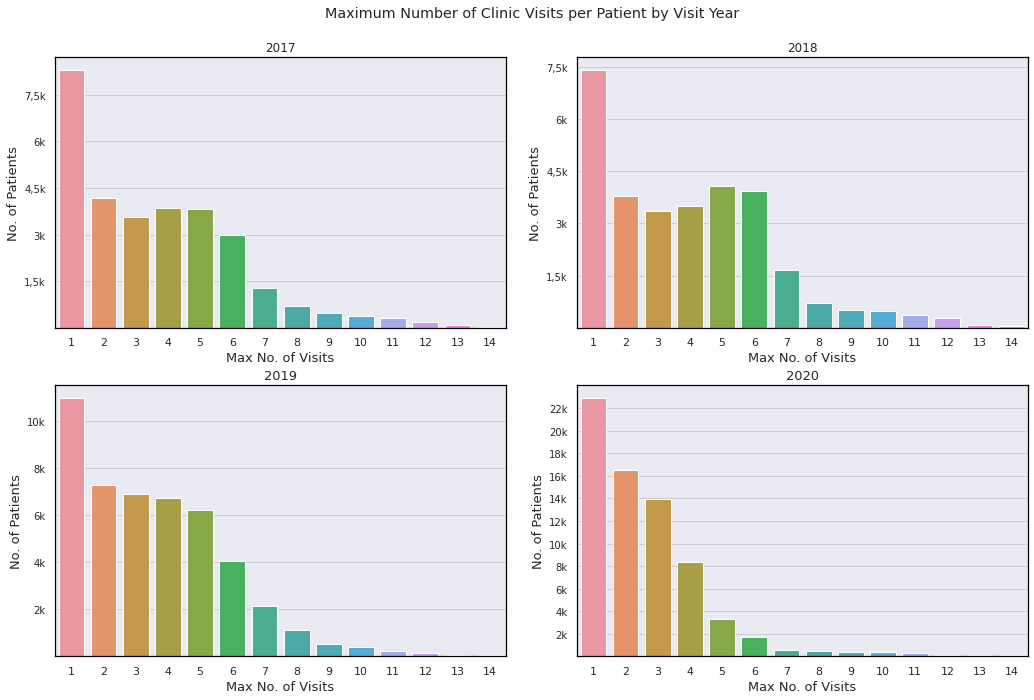

In [40]:
ave_visits11 = visits_2017.query('DATE_VISIT < 15')
ave_visits22 = visits_2018.query('DATE_VISIT < 15')
ave_visits33 = visits_2019.query('DATE_VISIT < 15')
ave_visits44 = visits_2020.query('DATE_VISIT < 15')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=3)
fig.suptitle('Maximum Number of Clinic Visits per Patient by Visit Year')

sns.barplot(ax=axes[0,0],data= ave_visits11,x=ave_visits11['DATE_VISIT'].astype('int'), y = ave_visits11['PATIENT_ID'].astype('int'))
axes[0,0].set_title('2017')
axes[0,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,0].set_ylabel('No. of Patients', fontsize=13)
axes[0,0].set_yticks([1500,3000,4500,6000,7500])
axes[0,0].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k'], fontsize=10)
axes[0,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,0].spines['bottom'].set_color('black')
axes[0,0].spines['top'].set_color('black') 
axes[0,0].spines['right'].set_color('black')
axes[0,0].spines['left'].set_color('black')

sns.barplot(ax=axes[0,1],data= ave_visits22,x=ave_visits22['DATE_VISIT'].astype('int'),y =  ave_visits22['PATIENT_ID'].astype('int'))
axes[0,1].set_title('2018')
axes[0,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[0,1].set_ylabel('No. of Patients', fontsize=13)
axes[0,1].set_yticks([1500,3000,4500,6000,7500])
axes[0,1].set_yticklabels(['1,5k','3k','4,5k','6k','7,5k'], fontsize=10)
axes[0,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[0,1].spines['bottom'].set_color('black')
axes[0,1].spines['top'].set_color('black') 
axes[0,1].spines['right'].set_color('black')
axes[0,1].spines['left'].set_color('black')

sns.barplot(ax=axes[1,0],data= ave_visits33,x=ave_visits33['DATE_VISIT'].astype('int'), y = ave_visits33['PATIENT_ID'].astype('int'))
axes[1,0].set_title('2019',fontsize=13)
axes[1,0].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,0].set_ylabel('No. of Patients', fontsize=13)
axes[1,0].set_yticks([2000,4000,6000,8000,10000])
axes[1,0].set_yticklabels(['2k','4k','6k','8k','10k'], fontsize=10)
axes[1,0].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,0].spines['bottom'].set_color('black')
axes[1,0].spines['top'].set_color('black') 
axes[1,0].spines['right'].set_color('black')
axes[1,0].spines['left'].set_color('black')

sns.barplot(ax=axes[1,1],data= ave_visits44,x=ave_visits44['DATE_VISIT'].astype('int'),y =  ave_visits44['PATIENT_ID'].astype('int'))
axes[1,1].set_title('2020',fontsize=13)
axes[1,1].set_xlabel('Max No. of Visits', fontsize=13)
axes[1,1].set_ylabel('No. of Patients', fontsize=13)
axes[1,1].set_yticks([2000,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000])
axes[1,1].set_yticklabels(['2k','4k','6k','8k','10k','12k','14k','16k','18k','20k','22k'], fontsize=10)
axes[1,1].grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
axes[1,1].spines['bottom'].set_color('black')
axes[1,1].spines['top'].set_color('black') 
axes[1,1].spines['right'].set_color('black')
axes[1,1].spines['left'].set_color('black')
plt.subplots_adjust(top=0.91)
plt.savefig("../Figures/clinic_visits_by_state_post2017_by_visit_year.png",transparent=True,bbox_inches="tight")